In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import ccxt
from datetime import datetime
from datetime import timedelta
import os
import talib
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
import time
from datetime import timedelta


%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('expand_frame_repr', False)  
pd.set_option("display.max_rows", 500) 
pd.set_option('display.max_columns', None) #防止column太多中间变成省略号

In [33]:
btc_d = pd.read_csv("./data/daily_data_BTC_USDT.csv")
btc_d['candle_begin_time'] = pd.to_datetime(btc_d['candle_begin_time'])
btc_d.set_index('candle_begin_time', inplace=True)
btc_d

,open,high,low,close,volume
candle_begin_time,,,,,
2017-08-17 08:00:00,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18 08:00:00,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19 08:00:00,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20 08:00:00,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21 08:00:00,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2022-02-28 08:00:00,37699.08,44225.84,37450.17,43160.00,73945.638580
2022-03-01 08:00:00,43160.00,44949.00,42809.98,44421.20,61743.098730
2022-03-02 08:00:00,44421.20,45400.00,43334.09,43892.98,57782.650810


<AxesSubplot:xlabel='candle_begin_time'>

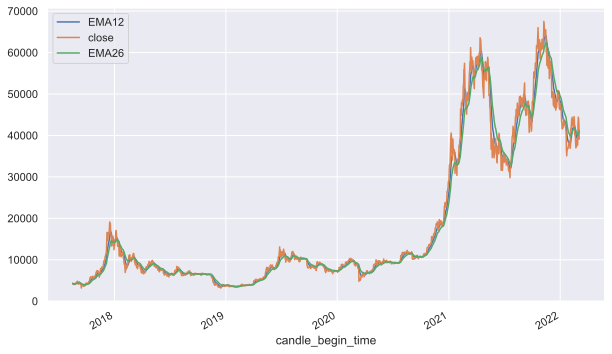

In [35]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# btc_d[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, color=['#961a01', '#660066', '#173508']) 
# btc_d[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, colormap='RdYlGn')
btc_d['EMA12'] = btc_d['close'].ewm(span=12).mean()
btc_d['EMA26'] = btc_d['close'].ewm(span=26).mean()
btc_d['DIF'] = btc_d['EMA12'] - btc_d['EMA26']
btc_d['SIG'] = btc_d['DIF'].ewm(span=9).mean()
btc_d['MACD'] = btc_d['DIF']-btc_d['SIG']
# btc_d[['gold', 'SMA', 'EMA']].plot(ax=ax,legend=True)
btc_d[['EMA12','close', 'EMA26']].plot(ax=ax,legend=True)
# plt.savefig("./images/gold_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='candle_begin_time'>

<AxesSubplot:xlabel='candle_begin_time'>

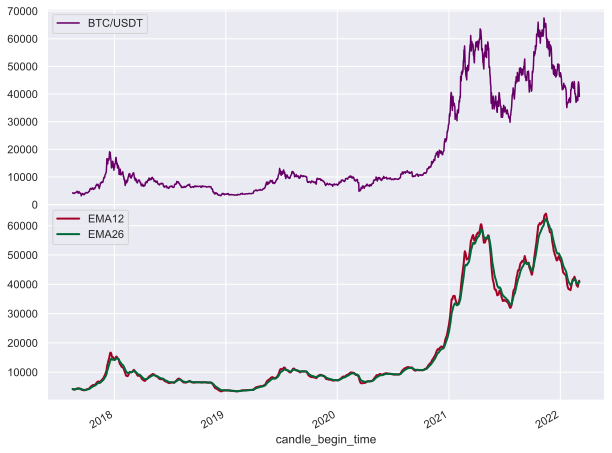

In [49]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
btc_d['close'].plot(ax=ax, color="#660066", legend=True, label="BTC/USDT");
ax.grid(True) 
btc_d[['EMA12','EMA26']].plot(ax=ax1, legend=True, colormap='RdYlGn', linewidth=2)
ax1.grid(True)
plt.subplots_adjust(hspace=0)
plt.savefig("./images/EMA_b", dpi=800)

<AxesSubplot:xlabel='candle_begin_time'>

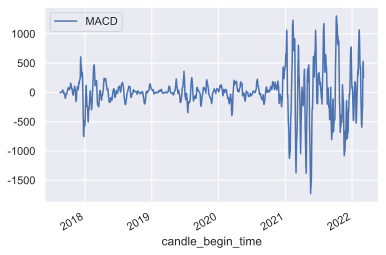

In [37]:
btc_d[['MACD']].plot(legend=True)

In [38]:
btc_h = pd.read_csv("./data/hourly_data_BTC_USDT.csv")
btc_h['candle_begin_time'] = pd.to_datetime(btc_h['candle_begin_time'])
btc_h.set_index('candle_begin_time', inplace=True)
btc_h

,open,high,low,close,volume
candle_begin_time,,,,,
2021-01-01 08:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
2021-01-01 09:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2021-01-01 10:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
2021-01-01 11:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
2021-01-01 12:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803
...,...,...,...,...,...
2022-03-04 19:00:00,41676.56,41904.88,41570.97,41662.07,1326.240830
2022-03-04 20:00:00,41662.06,41762.43,41340.23,41511.29,1734.155490
2022-03-04 21:00:00,41511.30,41833.00,41244.37,41315.76,2407.415790


<AxesSubplot:xlabel='candle_begin_time'>

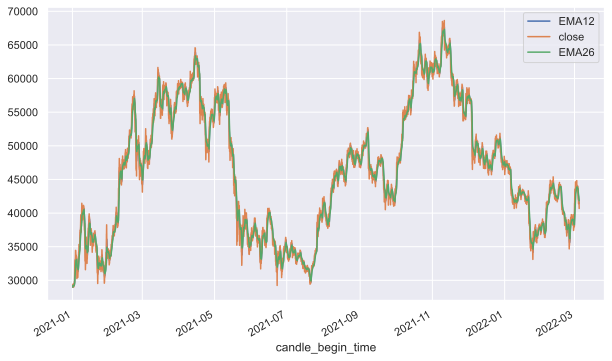

In [39]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# btc_h[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, color=['#961a01', '#660066', '#173508']) 
# btc_h[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, colormap='RdYlGn')
btc_h['EMA12'] = btc_h['close'].ewm(span=12).mean()
btc_h['EMA26'] = btc_h['close'].ewm(span=26).mean()
btc_h['DIF'] = btc_h['EMA12'] - btc_h['EMA26']
btc_h['SIG'] = btc_h['DIF'].ewm(span=9).mean()
btc_h['MACD'] = btc_h['DIF']-btc_h['SIG']
# btc_h[['gold', 'SMA', 'EMA']].plot(ax=ax,legend=True)
btc_h[['EMA12','close', 'EMA26']].plot(ax=ax,legend=True)
# plt.savefig("./images/gold_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='candle_begin_time'>

<AxesSubplot:xlabel='candle_begin_time'>

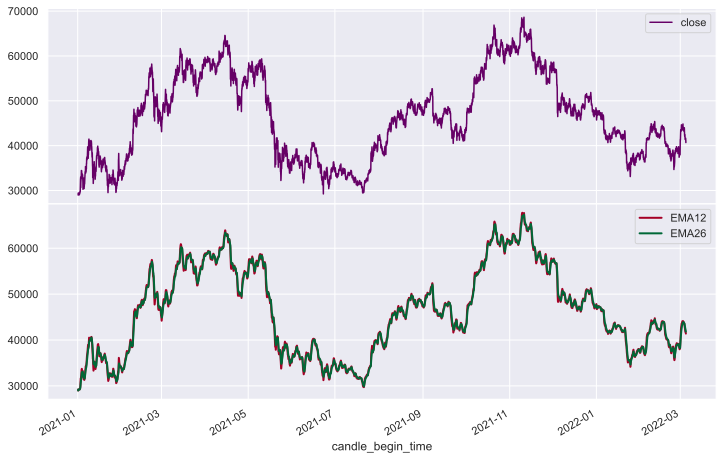

In [43]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
btc_h['close'].plot(ax=ax, color="#660066", legend=True);
ax.grid(True) 
btc_h[['EMA12','EMA26']].plot(ax=ax1, legend=True, colormap='RdYlGn', linewidth=2)
ax1.grid(True)
plt.subplots_adjust(hspace=0)

<AxesSubplot:xlabel='candle_begin_time'>

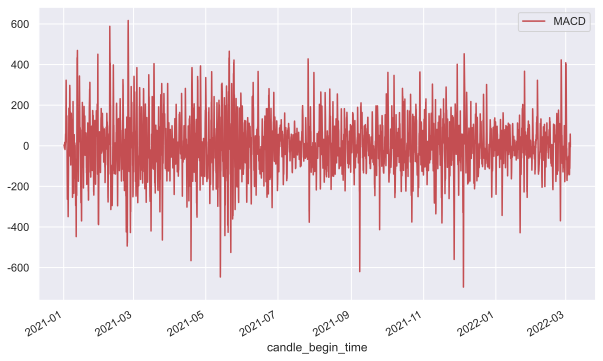

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
btc_h[['MACD']].plot(ax = ax,legend=True, color='r', label='BTC/USDT_h')
plt.savefig("./images/macd_b.png", dpi=800)

In [45]:
eth_d = pd.read_csv("./data/daily_data_ETH_USDT.csv")
eth_d['candle_begin_time'] = pd.to_datetime(eth_d['candle_begin_time'])
eth_d.set_index('candle_begin_time', inplace=True)
eth_d

,open,high,low,close,volume
candle_begin_time,,,,,
2017-08-17 08:00:00,301.13,312.18,298.00,302.00,7030.71034
2017-08-18 08:00:00,302.00,311.79,283.94,293.96,9537.84646
2017-08-19 08:00:00,293.31,299.90,278.00,290.91,2146.19773
2017-08-20 08:00:00,289.41,300.53,282.85,299.10,2510.13871
2017-08-21 08:00:00,299.10,346.52,294.60,323.29,5219.44542
...,...,...,...,...,...
2022-02-28 08:00:00,2616.79,2951.60,2568.62,2920.95,733794.44880
2022-03-01 08:00:00,2920.83,3037.94,2854.09,2976.33,673901.69760
2022-03-02 08:00:00,2976.33,3043.91,2914.21,2947.30,614623.74610


<AxesSubplot:xlabel='candle_begin_time'>

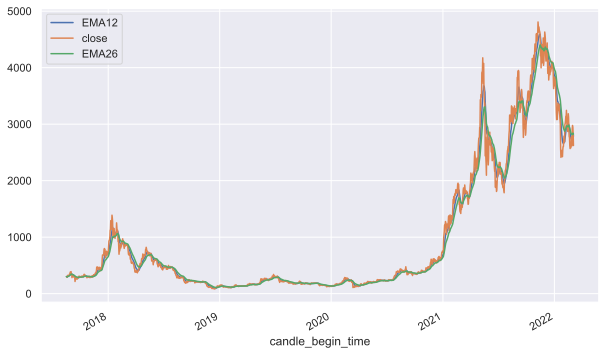

In [46]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# eth_d[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, color=['#961a01', '#660066', '#173508']) 
# eth_d[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, colormap='RdYlGn')
eth_d['EMA12'] = eth_d['close'].ewm(span=12).mean()
eth_d['EMA26'] = eth_d['close'].ewm(span=26).mean()
eth_d['DIF'] = eth_d['EMA12'] - eth_d['EMA26']
eth_d['SIG'] = eth_d['DIF'].ewm(span=9).mean()
eth_d['MACD'] = eth_d['DIF']-eth_d['SIG']
# eth_d[['gold', 'SMA', 'EMA']].plot(ax=ax,legend=True)
eth_d[['EMA12','close', 'EMA26']].plot(ax=ax,legend=True)
# plt.savefig("./images/gold_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='candle_begin_time'>

<AxesSubplot:xlabel='candle_begin_time'>

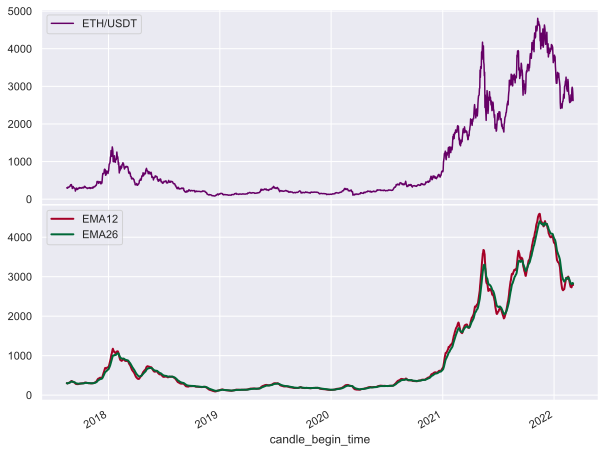

In [48]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
eth_d['close'].plot(ax=ax, color="#660066", legend=True, label='ETH/USDT');
ax.grid(True) 
eth_d[['EMA12','EMA26']].plot(ax=ax1, legend=True, colormap='RdYlGn', linewidth=2)
ax1.grid(True)
plt.subplots_adjust(hspace=0)
plt.savefig("./images/EMA_e", dpi=800)

In [60]:
eth_h = pd.read_csv("./data/hourly_data_ETH_USDT.csv")
eth_h['candle_begin_time'] = pd.to_datetime(eth_h['candle_begin_time'])
eth_h.set_index('candle_begin_time', inplace=True)
eth_h

,open,high,low,close,volume
candle_begin_time,,,,,
2021-01-01 08:00:00,736.42,739.00,729.33,734.07,27932.69884
2021-01-01 09:00:00,734.08,749.00,733.37,748.28,52336.18779
2021-01-01 10:00:00,748.27,749.00,742.27,744.06,33019.50100
2021-01-01 11:00:00,744.06,747.23,743.10,744.82,17604.80859
2021-01-01 12:00:00,744.87,747.09,739.30,742.29,18794.15424
...,...,...,...,...,...
2022-03-04 19:00:00,2741.80,2759.24,2736.74,2744.39,12033.64830
2022-03-04 20:00:00,2744.39,2750.26,2720.66,2730.11,17216.53660
2022-03-04 21:00:00,2730.11,2755.56,2715.00,2720.65,22235.77270


<AxesSubplot:xlabel='candle_begin_time'>

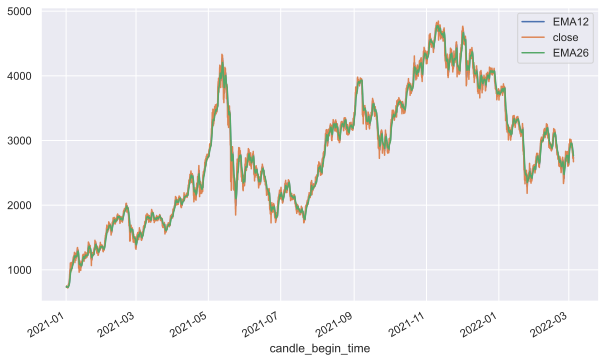

In [61]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# eth_h[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, color=['#961a01', '#660066', '#173508']) 
# eth_h[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, colormap='RdYlGn')
eth_h['EMA12'] = eth_h['close'].ewm(span=12).mean()
eth_h['EMA26'] = eth_h['close'].ewm(span=26).mean()
eth_h['DIF'] = eth_h['EMA12'] - eth_h['EMA26']
eth_h['SIG'] = eth_h['DIF'].ewm(span=9).mean()
eth_h['MACD'] = eth_h['DIF']-eth_h['SIG']
# eth_h[['gold', 'SMA', 'EMA']].plot(ax=ax,legend=True)
eth_h[['EMA12','close', 'EMA26']].plot(ax=ax,legend=True)
# plt.savefig("./images/gold_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='candle_begin_time'>

<AxesSubplot:xlabel='candle_begin_time'>

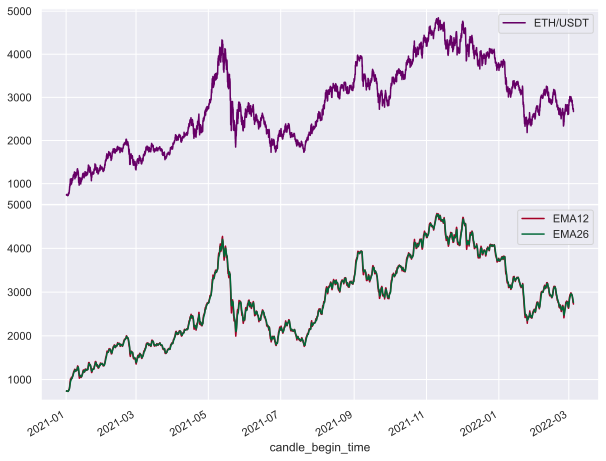

In [65]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))
eth_h['close'].plot(ax=ax, color="#660066", legend=True, label='ETH/USDT');
ax.grid(True) 
eth_h[['EMA12','EMA26']].plot(ax=ax1, legend=True, colormap='RdYlGn', linewidth=1.5)
ax1.grid(True)
plt.subplots_adjust(hspace=0)

<AxesSubplot:xlabel='candle_begin_time'>

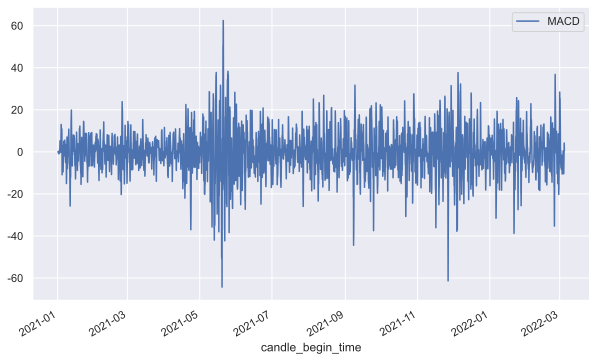

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
eth_h[['MACD']].plot(ax = ax,legend=True, color='b', label='ETH/USDT_h')
plt.savefig("./images/macd_e.png", dpi=800)